In [2]:

### System
import os
import joblib

### Set seed
import random
random.seed(42)

### Mains
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
%matplotlib inline 


# ### Models:
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier

# ### Ensemble Models:
# from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier

# ### Embeddings:
# from sklearn.manifold import TSNE

# ### Dats Splits 
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_validate

# ### Pipelines
# from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.preprocessing import StandardScaler 
# from sklearn.pipeline import Pipeline, make_pipeline 
# from sklearn.utils import shuffle

# # Sampling Methods
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.under_sampling import NearMiss, RandomUnderSampler

# ### Metrics:
# import sklearn.metrics as skm
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



2024-04-05 21:35:57.830676: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 21:35:57.831914: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 21:35:57.858390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 21:35:57.858953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 21:35:58.401738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [24]:
# df = pd.read_excel("data.csv.xlsx", sheet_name="train")

# df.to_pickle("data.pkl")

df = pd.read_pickle("data.pkl")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   transDate       181822 non-null  datetime64[ns]
 1   creditCardNum   181822 non-null  int64         
 2   business        181822 non-null  object        
 3   category        181822 non-null  object        
 4   amount          181822 non-null  float64       
 5   firstName       181822 non-null  object        
 6   lastName        181822 non-null  object        
 7   gender          181822 non-null  object        
 8   street          181822 non-null  object        
 9   city            181822 non-null  object        
 10  state           181822 non-null  object        
 11  zip             181822 non-null  int64         
 12  latitude        181822 non-null  float64       
 13  longitude       181822 non-null  float64       
 14  cityPop         181822 non-null  int

In [5]:
# drop first & last name

df = df.drop(columns=['firstName', 'lastName', ])

In [6]:
df.describe()

,transDate,creditCardNum,amount,zip,latitude,longitude,cityPop,dateOfBirth,unixTime,merchLatitude,merchLongitude,isFraud
count,181822,1.818220e+05,181822.000000,181822.000000,181822.000000,181822.000000,1.818220e+05,181822,1.818220e+05,181822.000000,181822.000000,181822.000000
mean,2019-09-25 01:50:12.451688704,4.166126e+17,70.844358,48736.463723,38.521137,-90.167556,8.910380e+04,1973-08-27 03:33:31.122966432,1.348538e+09,38.519817,-90.168233,0.007348
min,2019-01-01 04:28:00,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1924-10-30 00:00:00,1.325392e+09,19.034282,-166.657174,0.000000
25%,2019-08-11 17:28:08,1.800429e+14,9.670000,26237.000000,34.590600,-96.786900,7.430000e+02,1962-06-04 00:00:00,1.344706e+09,34.716436,-96.856711,0.000000
50%,2019-10-07 16:17:32,3.521417e+15,47.490000,48088.000000,39.346500,-87.458100,2.457000e+03,1975-09-11 00:00:00,1.349627e+09,39.358796,-87.396030,0.000000
75%,2019-10-27 21:51:47.750000128,4.642255e+15,83.470000,72011.000000,41.846700,-80.158000,2.047800e+04,1987-02-13 00:00:00,1.351375e+09,41.933726,-80.231080,0.000000
max,2019-12-15 13:49:26,4.992346e+18,10926.440000,99783.000000,65.689900,-67.950300,2.906700e+06,2005-01-29 00:00:00,1.355579e+09,66.653465,-66.977475,1.000000
std,NaN,1.307939e+18,146.108136,26858.467937,5.066262,13.710668,3.028215e+05,NaN,3.868345e+06,5.101595,13.721601,0.085404


In [7]:
print(df.shape)
df.head()

(181822, 20)


,transDate,creditCardNum,business,category,amount,gender,street,city,state,zip,latitude,longitude,cityPop,job,dateOfBirth,transNum,unixTime,merchLatitude,merchLongitude,isFraud
0,2019-01-01 04:28:00,4119762878330980,fraud_Welch Inc,misc_net,4.10,F,1497 West Gateway,Eureka,IL,61530,40.7152,-89.2706,6713,Archivist,1945-08-19,3fc1791ff1db94ce9540262d7eb973e4,1325392080,40.020043,-89.693412,0
1,2019-01-01 04:28:15,36078114201167,fraud_Auer-West,shopping_net,2.67,M,956 Sanchez Highway,Mallie,KY,41836,37.2692,-82.9161,798,Facilities manager,1926-06-26,edbf65b8606b53fc48168c2daa5933e5,1325392095,37.622362,-82.676007,0
2,2019-01-01 04:29:14,4449530933957320,fraud_Balistreri-Nader,misc_pos,22.88,F,84079 Thomas Burgs,Tomales,CA,94971,38.2427,-122.9145,337,Occupational psychologist,1954-07-05,2fcbde131cff833751dde53da54da6da,1325392154,39.060101,-121.969417,0
3,2019-01-01 04:29:18,4302475216404890,"fraud_Boehm, Predovic and Reinger",misc_pos,9.59,M,384 Newman Forks Apt. 370,Belmond,IA,50421,42.8511,-93.6200,3032,Community pharmacist,1964-08-08,bcae564f9a1a299dfbd1efd917499968,1325392158,43.280848,-94.340312,0
4,2019-01-01 04:32:09,377234009633447,fraud_Hudson-Ratke,grocery_pos,129.06,F,43576 Kristina Islands,Shenandoah Junction,WV,25442,39.3716,-77.8229,1925,Systems developer,1966-02-14,5e42e35c255edb55a192b3f1f0600936,1325392329,39.211630,-78.409044,0


In [8]:
df.isnull().sum()   

transDate         0
creditCardNum     0
business          0
category          0
amount            0
gender            0
street            0
city              0
state             0
zip               0
latitude          0
longitude         0
cityPop           0
job               0
dateOfBirth       0
transNum          0
unixTime          0
merchLatitude     0
merchLongitude    0
isFraud           0
dtype: int64

In [9]:
fraud = df[df.isFraud == 1]
normal = df[df.isFraud == 0]

print(f"Num Total txns: {df.shape[0]}")
print(f"Num fraud txns: {fraud.shape[0]}")
print(f"Num normal txns: {normal.shape[0]}")
print(f"% of fraud of all: {fraud.shape[0] / df.shape[0] * 100:.4f}%")


Num Total txns: 181822
Num fraud txns: 1336
Num normal txns: 180486
% of fraud of all: 0.7348%


### Latidue Longitude plot 

In [21]:
df[df['isFraud'] == 1].shape[0]

1336

ValueError: 'c' argument has 181822 elements, which is inconsistent with 'x' and 'y' with size 1336.

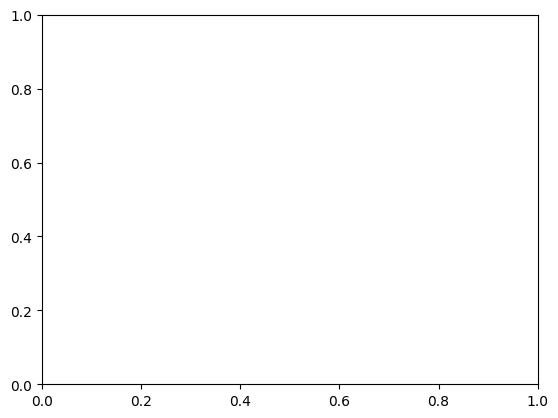

In [22]:
df = fraud
colors = df['isFraud'].map({1: 'black', 0: 'blue'})
plt.scatter(x=df['longitude'], y=df['latitude'], c=colors)
plt.show()